In [4]:
# Librerias necesarias
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix
from pathlib import Path
import gzip
import pickle
import os

In [5]:
# Visualizacion de datasets con pandas
# Cargar un datasets
# Dataset llamado: test_data.csv.zip y train_data.csv.zip

train_data = pd.read_csv('../files/input/train_data.csv.zip', compression='zip')
test_data = pd.read_csv('../files/input/test_data.csv.zip', compression='zip')

In [6]:
def clean_datasets(df1, df2):
    # Renombre la columna "default payment next month" a "default"
    df1 = df1.rename(columns={"default payment next month": "default"})
    df2 = df2.rename(columns={"default payment next month": "default"})

    # Remueva la columna "ID"
    df1 = df1.drop(columns=["ID"])
    df2 = df2.drop(columns=["ID"])

    # Elimine los registros con informacion no disponible
    # 1. Registros con "?" (valores faltantes como string)
    df1 = df1.replace("?", pd.NA)
    df2 = df2.replace("?", pd.NA)
    
    # 2. Registros donde EDUCATION = 0 (N/A)
    df1 = df1[df1['EDUCATION'] != 0]
    df2 = df2[df2['EDUCATION'] != 0]
    
    # 3. Registros donde MARRIAGE = 0 (N/A)
    df1 = df1[df1['MARRIAGE'] != 0]
    df2 = df2[df2['MARRIAGE'] != 0]
    
    # 4. Eliminar cualquier NA restante
    df1 = df1.dropna()
    df2 = df2.dropna()

    # Para la columna EDUCATION, valores > 4 indican niveles superiores
    # de educación, agrupe estos valores en la categoría 4 (others).
    df1['EDUCATION'] = df1['EDUCATION'].apply(lambda x: 4 if x > 4 else x)
    df2['EDUCATION'] = df2['EDUCATION'].apply(lambda x: 4 if x > 4 else x)

    return df1, df2

train_data, test_data = clean_datasets(train_data, test_data)

In [7]:
# Paso 2.
# Divida los datasets en x_train, y_train, x_test, y_test.

# Separar características (X) y objetivo (y) del conjunto de entrenamiento
x_train = train_data.drop(columns=['default'])
y_train = train_data['default']

# Separar características (X) y objetivo (y) del conjunto de prueba
x_test = test_data.drop(columns=['default'])
y_test = test_data['default']

In [8]:
# Paso 3.
# Cree un pipeline para el modelo de clasificación. Este pipeline debe
# contener las siguientes capas:

def create_pipeline(x_train, y_train):

    # Define qué columnas son categóricas
    categorical_features = ['SEX', 'EDUCATION', 'MARRIAGE']

    # Crea el transformador
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ],
        remainder='passthrough'  # Las demás columnas se dejan sin cambios
    )

    # Creacion del pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),      # Paso 1: transformar datos
        ('classifier', RandomForestClassifier(random_state=42))  # Paso 2: modelo
    ])

    # Optimización de hiperparámetros con cross-validation usando balanced accuracy
    param_grid = {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [10, 20, None],
        'classifier__min_samples_split': [2, 5]
    }

    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        cv=10,
        scoring='balanced_accuracy',
        n_jobs=-1,
        verbose=1
    )

    # Esto entrena automáticamente con los mejores parámetros
    grid_search.fit(x_train, y_train)
    
    print(f'Mejores parámetros: {grid_search.best_params_}')
    print(f'Mejor balanced_accuracy (CV): {grid_search.best_score_:.4f}')

    return grid_search

# Verificar si el modelo ya existe
model_path = Path('../files/models/model.pkl.gz')

if model_path.exists():
    print("⚡ Cargando modelo existente...")
    with gzip.open(model_path, 'rb') as f:
        pipeline = pickle.load(f)
    print("✅ Modelo cargado exitosamente!")
else:
    print("🔄 Entrenando nuevo modelo...")
    pipeline = create_pipeline(x_train, y_train)
    
    # Guardar el modelo
    os.makedirs('../files/models', exist_ok=True)
    with gzip.open(model_path, 'wb') as f:
        pickle.dump(pipeline, f)
    print("✅ Modelo entrenado y guardado!")

⚡ Cargando modelo existente...
✅ Modelo cargado exitosamente!


In [9]:
# import gzip
# import pickle
# import os

# # Guardar el modelo comprimido como "files/models/model.pkl.gz"
# os.makedirs('../files/models', exist_ok=True)
# with gzip.open('../files/models/model.pkl.gz', 'wb') as f:
#     pickle.dump(pipeline, f)

In [10]:
# Calcule las metricas de precision, precision balanceada, recall,
# y f1-score para los conjuntos de entrenamiento y prueba.

y_train_pred = pipeline.predict(x_train)
y_test_pred = pipeline.predict(x_test)

print("Training Metrics:")

# Métricas para el conjunto de entrenamiento
# Aproximar a 3 decimales
Precision_train = round(precision_score(y_train, y_train_pred), 3)
print(f"Precision: {Precision_train}")
Balanced_Accuracy_train = round(balanced_accuracy_score(y_train, y_train_pred), 3)
print(f"Balanced Accuracy: {Balanced_Accuracy_train}")
Precision_train = round(precision_score(y_train, y_train_pred), 3)
print(f"Precision: {Precision_train}")
Recall_train = round(recall_score(y_train, y_train_pred), 3)
print(f"Recall: {Recall_train}")
F1_Score_train = round(f1_score(y_train, y_train_pred), 3)
print(f"F1 Score: {F1_Score_train}")

# Métricas para el conjunto de prueba
print("\nTesting Metrics:")
Precision_test = round(precision_score(y_test, y_test_pred), 3)
print(f"Precision: {Precision_test}")
Balanced_Accuracy_test = round(balanced_accuracy_score(y_test, y_test_pred), 3)
print(f"Balanced Accuracy: {Balanced_Accuracy_test}")
Precision_test = round(precision_score(y_test, y_test_pred), 3)
print(f"Precision: {Precision_test}")
Balanced_Accuracy_test = round(balanced_accuracy_score(y_test, y_test_pred), 3)
print(f"Balanced Accuracy: {Balanced_Accuracy_test}")
Precision_test = round(precision_score(y_test, y_test_pred), 3)
print(f"Precision: {Precision_test}")
Recall_test = round(recall_score(y_test, y_test_pred), 3)
print(f"Recall: {Recall_test}")
F1_Score_test = round(f1_score(y_test, y_test_pred), 3)
print(f"F1 Score: {F1_Score_test}")


Training Metrics:
Precision: 0.998
Balanced Accuracy: 0.973
Precision: 0.998
Recall: 0.947
F1 Score: 0.972

Testing Metrics:
Precision: 0.655
Balanced Accuracy: 0.675
Precision: 0.655
Balanced Accuracy: 0.675
Precision: 0.655
Recall: 0.409
F1 Score: 0.503


In [11]:
import json

# Guardar las metricas en el archivo files/output/metrics.json.
# Métricas de entrenamiento
train_metrics = {
    'type': 'metrics',  
    'dataset': 'train',
    'precision': round(precision_score(y_train, y_train_pred), 3),
    'balanced_accuracy': round(balanced_accuracy_score(y_train, y_train_pred), 3),
    'recall': round(recall_score(y_train, y_train_pred), 3),
    'f1_score': round(f1_score(y_train, y_train_pred), 3)
}

# Métricas de prueba
test_metrics = {
    'type': 'metrics', 
    'dataset': 'test',
    'precision': round(precision_score(y_test, y_test_pred), 3),
    'balanced_accuracy': round(balanced_accuracy_score(y_test, y_test_pred), 3),
    'recall': round(recall_score(y_test, y_test_pred), 3),
    'f1_score': round(f1_score(y_test, y_test_pred), 3)
}

# Crear carpeta si no existe
os.makedirs('../files/output', exist_ok=True)

with open("../files/output/metrics.json", "w") as f:
    f.write(json.dumps(train_metrics) + '\n')
    f.write(json.dumps(test_metrics) + '\n')

In [ ]:
# Calcular las matrices de confusion para los conjuntos de entrenamiento y
# prueba

from sklearn.metrics import confusion_matrix

confusion_matrix_train = confusion_matrix(y_train, y_train_pred)
confusion_matrix_test = confusion_matrix(y_test, y_test_pred)

matrix_train = {
    'type': 'cm_matrix',
    'dataset': 'train', 
    'true_0': {"predicted_0": int(confusion_matrix_train[0][0]), 
            "predicted_1": int(confusion_matrix_train[0][1])}, 
    'true_1': {"predicted_0": int(confusion_matrix_train[1][0]), 
            "predicted_1": int(confusion_matrix_train[1][1])}
}

matrix_test = {
    'type': 'cm_matrix',
    'dataset': 'test',
    'true_0': {"predicted_0": int(confusion_matrix_test[0][0]), 
            "predicted_1": int(confusion_matrix_test[0][1])},
    'true_1': {"predicted_0": int(confusion_matrix_test[1][0]),
            "predicted_1": int(confusion_matrix_test[1][1])}
}

with open("../files/output/metrics.json", "a") as f:
    f.write(json.dumps(matrix_train) + '\n')
    f.write(json.dumps(matrix_test) + '\n')

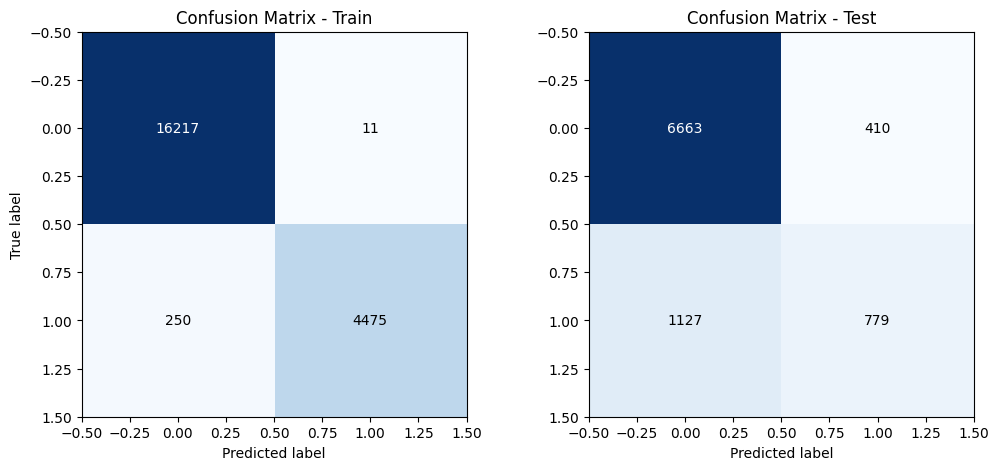

In [16]:
import matplotlib.pyplot as plt

# Mostrar las matrices de confusion mostrando los numeros dentro de cada celda
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)
im1 = ax[0].imshow(cm_train, cmap='Blues')
im2 = ax[1].imshow(cm_test, cmap='Blues')
for i in range(2):
    for j in range(2):
        ax[0].text(j, i, cm_train[i, j], ha='center', va='center', color='white' if cm_train[i, j] > cm_train.max()/2 else 'black')
        ax[1].text(j, i, cm_test[i, j], ha='center', va='center', color='white' if cm_test[i, j] > cm_test.max()/2 else 'black')
ax[0].set_title('Confusion Matrix - Train')
ax[1].set_title('Confusion Matrix - Test')
ax[0].set_xlabel('Predicted label')
ax[0].set_ylabel('True label')
ax[1].set_xlabel('Predicted label')
plt.show()

